### import necessary libraries

In [1]:
import cv2    # pip install opencv-python

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image   # pip install Pillow

import numpy as np

from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage import img_as_ubyte, img_as_float
from skimage.exposure import histogram, cumulative_distribution

### read image in 2D array

In [2]:
image = cv2.imread('Hi.tif', cv2.IMREAD_GRAYSCALE)

In [3]:
logo = cv2.imread('iut.tif', cv2.IMREAD_GRAYSCALE)

### function for show image 

In [4]:
def ShowImage(img, title="no title", subplot=111):
    if type(subplot)!=tuple :
        plt.subplot(subplot)
    else :
        plt.subplot(*subplot)
    plt.imshow( img, cmap='gray', vmin=0, vmax=255 )
    plt.title( title, fontweight ="bold")

### Q1

In [5]:
def hist_cdf(img, returned=False):
    hist_array, bin_array = np.histogram(img.flatten(), 256, [0, 256])

    cdf = hist_array.cumsum() / img.size
    
    if returned :
        return cdf
    
    plt.figure(figsize=[15, 5])
    
    plt.subplot(121)
    plt.xlim(min(bin_array), max(bin_array))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('intensity levels', fontsize=20)
    plt.ylabel('frequency', fontsize=20)
    plt.title('PDF', fontsize=25)
    plt.hist(img.flatten(), 256, [0, 256], color='blue')
    #plt.bar(bin_array[:-1], hist_array, width=0.5, color='blue')

    plt.subplot(122)
    plt.xlim(min(bin_array), max(bin_array))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('intensity levels', fontsize=20)
    plt.ylabel('cumulative probabilities', fontsize=20)
    plt.title('CDF', fontsize=25)
    plt.plot( cdf , color='red')
    #plt.bar(bin_array[:-1], cdf, width=0.5, color='red')
    
    plt.show()

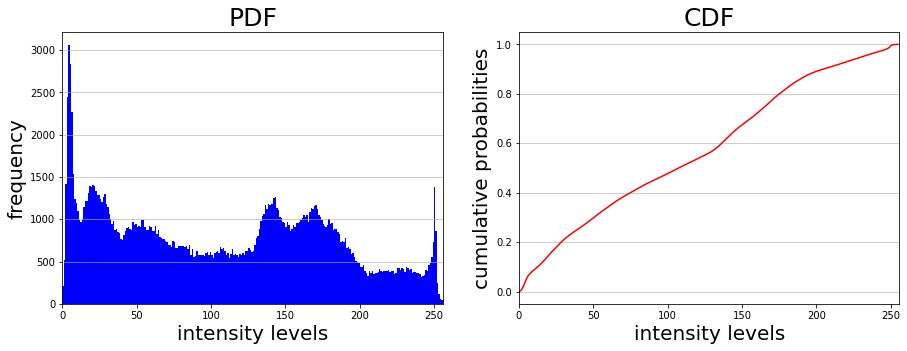

In [6]:
hist_cdf(image)

### Q2

https://github.com/jagracar/OpenCV-python-tests/blob/master/OpenCV-tutorials/imageProcessing/histogramEqualization.py


In [7]:
def hw2_histeq(image, returned=False, show=True):
    equalizeFunction = np.uint8( hist_cdf(image, True)*255 )
     
    equalizedImg = equalizeFunction[image]
    
    if show:
        hist_cdf( equalizedImg )
    
    if returned:
        return equalizedImg

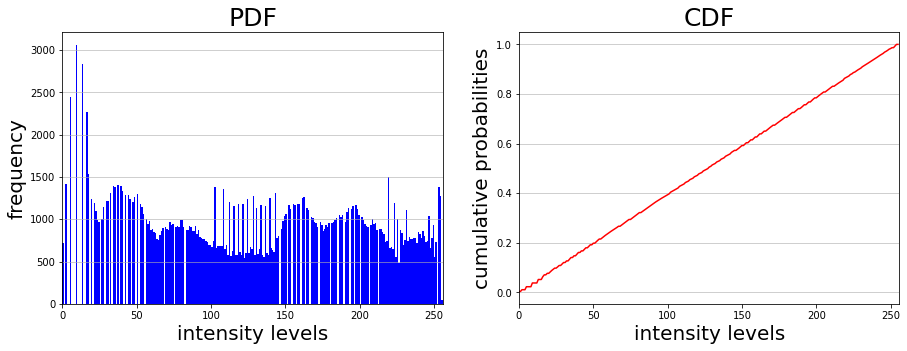

In [8]:
equalizedImg = hw2_histeq(image, True)

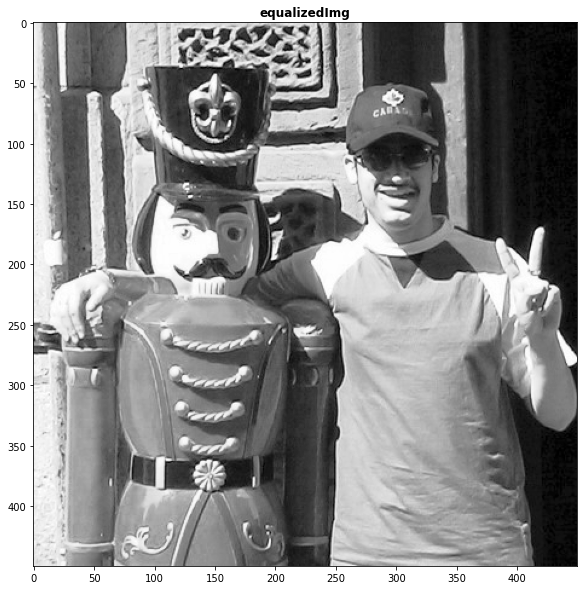

In [9]:
plt.figure(figsize=[10, 10])
ShowImage(equalizedImg, "equalizedImg")

### Q3

In [10]:
def hw2_local_histeq(image, n):
    Height, Width = image.shape

    Xpad = n-Height%n if Height%n else 0
    Ypad = n-Width%n if Width%n else 0
    
    #method 1
    tmp = np.pad(image, ((0, Xpad), (0, Ypad)), mode='constant', constant_values=0)
    #method 2
#     tmp = np.r_[ image, image[-Xpad:] ] 
#     tmp = np.c_[ tmp, tmp[:, -Ypad:] ]
    
    for i in range(tmp.shape[0]//n):
        for j in range(tmp.shape[1]//n):
            tmp[i*n:(i+1)*n, j*n:(j+1)*n] = hw2_histeq(tmp[i*n:(i+1)*n, j*n:(j+1)*n], True, False)
            
    return tmp[:Height, :Width]

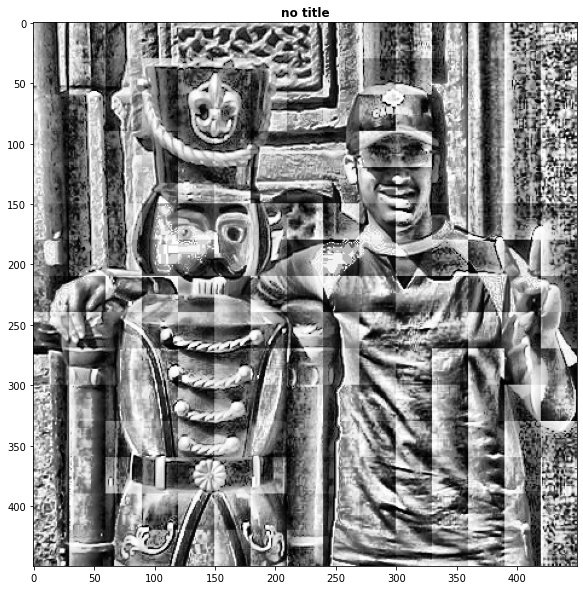

In [11]:
local_histeq = hw2_local_histeq(image, 30)
plt.figure(figsize=[10, 10])
ShowImage(local_histeq)

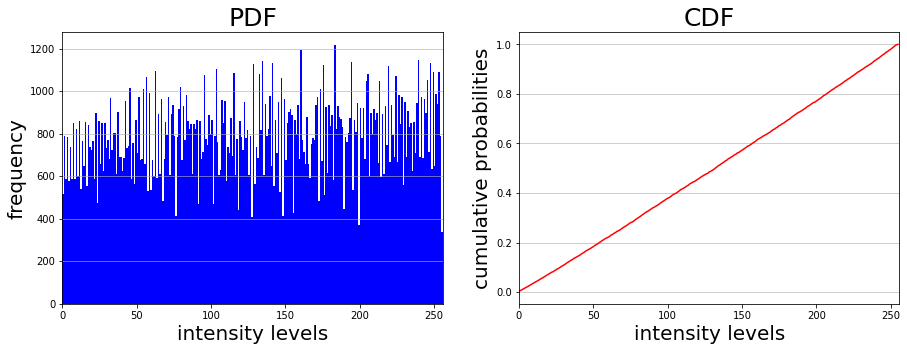

In [12]:
hist_cdf( local_histeq )

### Q4

<div align='right' dir="rtl" style='font-family:"B Nazanin"; font-size:20px; line-height: 200%;'><p>

تابعی جهت تغییر سایز تصویر

</p></div>

In [13]:
def imresize(Input_image, dim , interpolation=cv2.INTER_LINEAR):
    return cv2.resize(Input_image, dim, interpolation=interpolation)

<div align='right' dir="rtl" style='font-family:"B Nazanin"; font-size:20px; line-height: 200%;'><p>

تابعی جهت گرفتن ماتریسی از بیت L ام تصویر
و L بین 0 تا 7
</p></div>

In [14]:
def bitget(img, L):
    assert L<8, 'L should less than 8'
    return np.where(img&(1<<L) ,255,0)

<div align='right' dir="rtl" style='font-family:"B Nazanin"; font-size:20px; line-height: 200%;'><p>

تابعی جهت ست کردن بیت L ام در num1 اگر num2 صفر نباشد
</p></div>

In [15]:
def bitset(num1, bit, num2):
    assert bit<8, 'bit should less than 8'
    return ( num1&(~(1<<bit)) ) | (num2>0)<<bit

<div align='right' dir="rtl" style='font-family:"B Nazanin"; font-size:20px; line-height: 200%;'><p>

نمایش 8 تصویر به ازای هر لایه(بیت) از تصویر ورودی

</p></div>

In [16]:
def show_all_bit(img):
    plt.figure(figsize=[20, 10])
    for i in range(8):
        ShowImage( bitget(img,i) , f'{i+1}', 241+i)

<div align='right' dir="rtl" style='font-family:"B Nazanin"; font-size:20px; line-height: 200%;'><p>

تابعی جهت بررسی عدم سرریز بافر

</p></div>

In [17]:
def Check_uint8_range(k):
    if k < 0 :
        return 0
    if k > 255 :
        return 255
    return k

<div align='right' dir="rtl" style='font-family:"B Nazanin"; font-size:20px; line-height: 200%;'><p>

تابع دایتر جهت تک بیتی سایزی عکس ورودی
</p></div>

In [18]:
def dither(img):
    Height, Width = img.shape
    Floyd = np.copy(img).astype(np.float64)
    
    for i in range(Height):
        for j in range(Width):
            val = Floyd[i,j]
            if val < 128 :
                err = val
                Floyd[i,j] = 0
            else :
                err = val - 255
                Floyd[i,j] = 255
                
            a = (i+1) < Height
            b = (j+1) < Width
            c = (j-1) >= 0
            
            if b :
                Floyd[i, j+1] = Check_uint8_range( Floyd[i, j+1] + err*(7 / 16) )
            if a and c :
                Floyd[i+1, j-1] = Check_uint8_range( Floyd[i+1, j-1] + err*(3 / 16) )
            if a :
                Floyd[i+1, j] = Check_uint8_range( Floyd[i+1, j] + err*(5 / 16) )
            if a and b :
                Floyd[i+1, j+1] = Check_uint8_range( Floyd[i+1, j+1] + err*(1 / 16) )

    return Floyd.astype(np.uint8)

In [19]:
def hw2_hide(image, logo, L, show=True):
    Height, Width = image.shape
    watermarked = np.copy(image)
    logo = imresize(logo, image.shape, cv2.INTER_CUBIC  )
    J = dither(logo)  #halftone the msg
    
    for i in range(Height):
        for j in range(Width):
            watermarked[i, j] =  bitset(watermarked[i, j], L, J[i, j])
    
    if show :
        plt.figure(figsize=[20, 20])
        ShowImage( image , "Orginal Cover Image", 221)
        ShowImage( bitget(image, L) , f"{L}th bit-slice before embedding", 222)
        ShowImage( image , "Orginal Cover Image", 221)
        ShowImage( J , "Logo", 223)
        ShowImage( watermarked , "watermarked image", 224)
    
    return watermarked

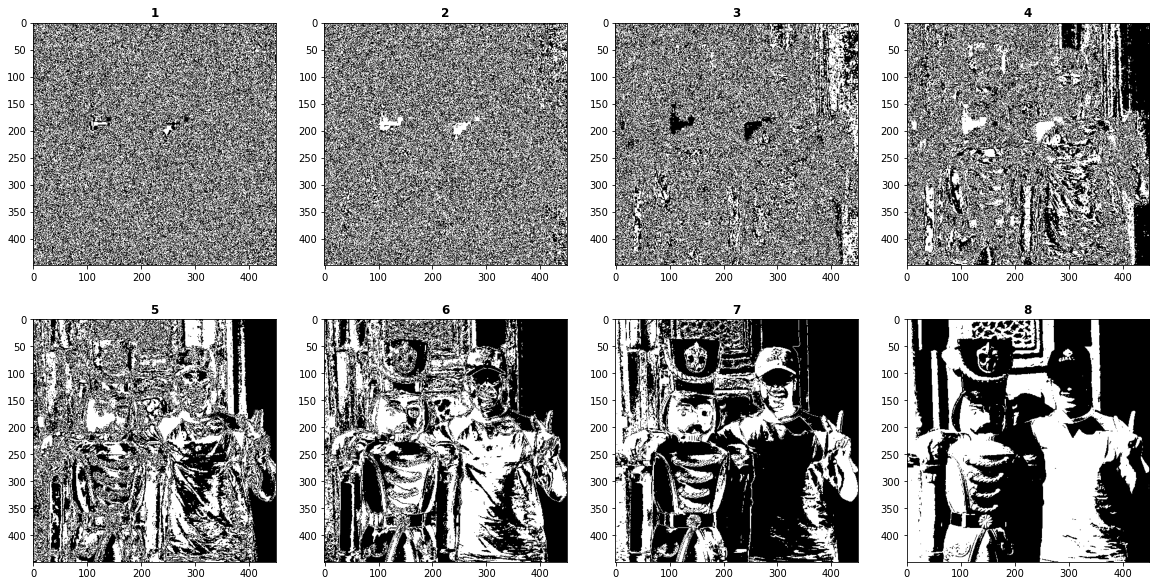

In [20]:
show_all_bit(image)

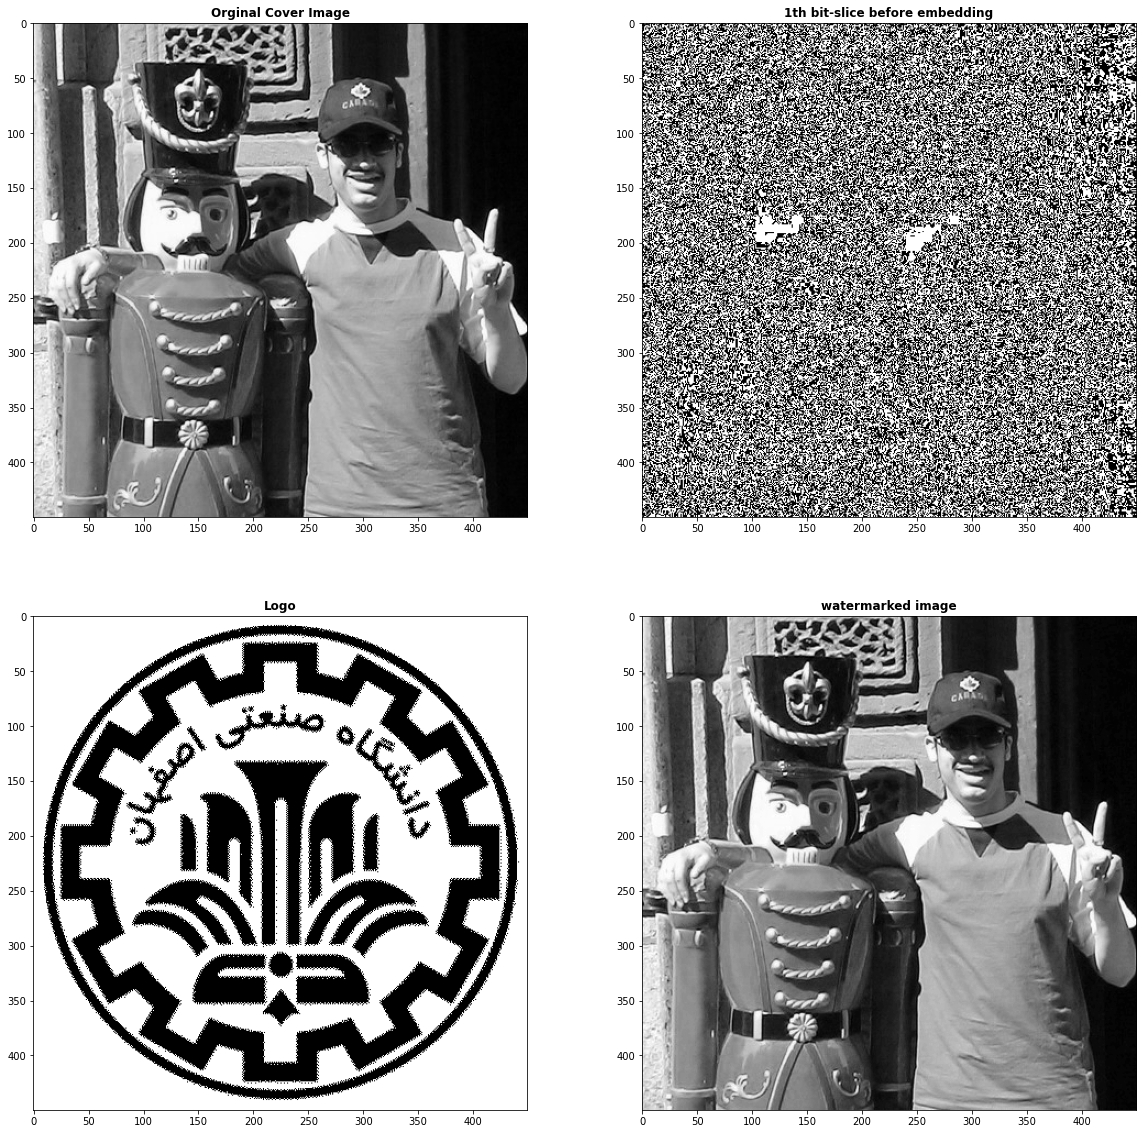

In [21]:
watermarked = hw2_hide(image, logo, 1)

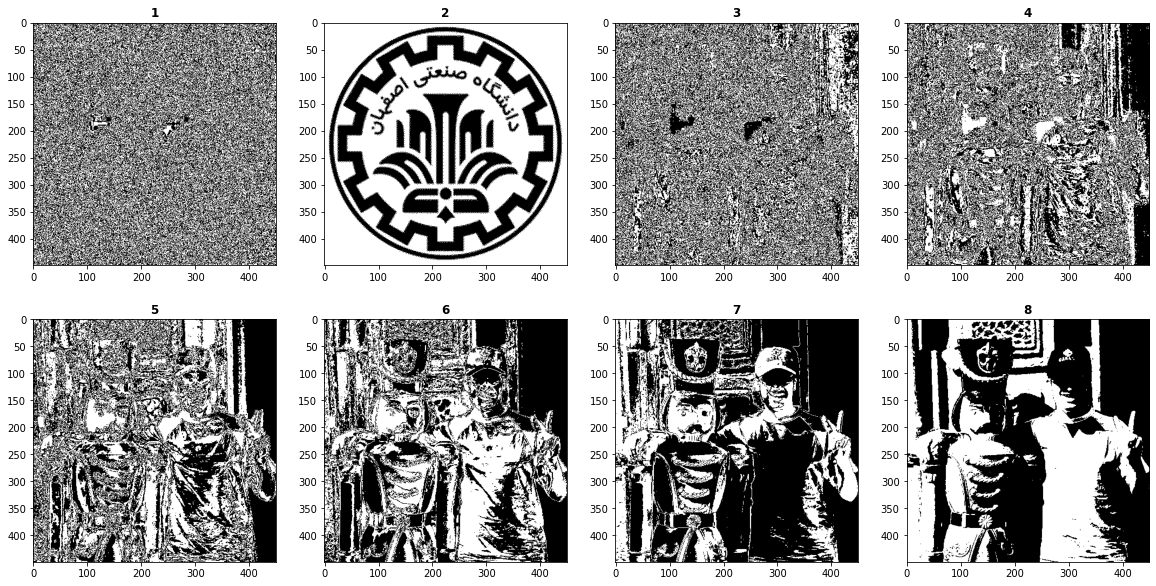

In [22]:
show_all_bit(watermarked)

In [23]:
# https://stackoverflow.com/questions/16774849
def HW1_MSE(img1, img2):
    assert img1.shape==img2.shape, 'images should equal size'
    return np.square(np.subtract(img1.astype(int), img2.astype(int))).mean(axis=None)

In [24]:
for i in range(8):
    watermarked = hw2_hide(image, logo, i, False)
    print(f"for watermarked at bit {i} MSE = {HW1_MSE(image, watermarked)}")

for watermarked at bit 0 MSE = 0.49949629629629627
for watermarked at bit 1 MSE = 2.0095802469135804
for watermarked at bit 2 MSE = 7.939476543209876
for watermarked at bit 3 MSE = 33.50629135802469
for watermarked at bit 4 MSE = 134.54222222222222
for watermarked at bit 5 MSE = 553.8550518518518
for watermarked at bit 6 MSE = 2251.202054320988
for watermarked at bit 7 MSE = 8341.033718518518
